In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm

In [2]:
from collections import namedtuple


#code from https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py#L55
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                        # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
      Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [3]:
n_classes = len(labels)
image_size =[128,128]
image_shape = [128, 128, 3]
epochs = 20
batch_  =20

id_color = {label.id : np.asarray(label.color) for label in labels}


In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_path = '/content/drive/MyDrive/DL/cityscapes_data/train'
val_path = '/content/drive/MyDrive/DL/cityscapes_data/val'

In [6]:
#--------------------------------------------------------------------------------
# Remap mask half of image into sparse matrix using closest color value
#--------------------------------------------------------------------------------

def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary

    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)

    return closest_category


In [7]:
train_images=[]
train_masks=[]
val_images=[]
val_masks=[]
def load_images(path):
    temp_img,temp_mask, enc_mask =[],[], []
    for image_name in tqdm(os.listdir(path)):
        image_path = os.path.join(path, image_name)
        if image_path.endswith('.jpg'):
          i = cv2.imread(image_path)
          img=i[:,:256] /255.0
          msk=i[:,256:]
          img = cv2.resize(img, (128,128))
          msk = cv2.resize(msk, (128,128))
          temp_img.append(img)
          enc_mask.append(find_closest_labels_vectorized(msk, id_color ))
          msk=i[:,256:] /255.0
          temp_mask.append(msk)




    return temp_img,temp_mask, enc_mask

train_images,train_masks, train_masks_enc =load_images(train_path)
val_images,val_masks, val_masks_enc =load_images(val_path)

100%|██████████| 500/500 [00:19<00:00, 25.39it/s]


In [8]:
print(train_masks_enc[0])

[[0 0 0 ... 0 0 0]
 [11 11 11 ... 11 11 11]
 [11 11 11 ... 11 11 11]
 ...
 [11 7 7 ... 7 7 6]
 [11 7 7 ... 7 7 11]
 [27 6 6 ... 6 6 6]]


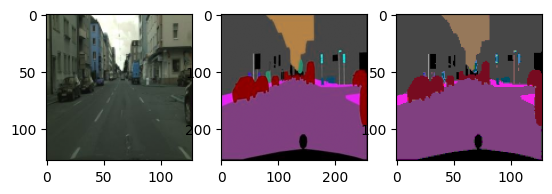

In [60]:
img = train_images[0]
msk = train_masks[0]
enc = train_masks_enc[0]
enc_vis = np.zeros([enc.shape[0],enc.shape[1], 3])

for row in range(enc.shape[0]):
    for col in range(enc.shape[1]):
        enc_vis[row, col, :] = id_color[enc[row, col]]
        enc_vis = enc_vis.astype('uint8')
plt.subplot(1,3,1)
plt.imshow(img)

plt.subplot(1,3,2)
plt.imshow(msk)

plt.subplot(1,3,3)
plt.imshow(enc_vis)

plt.show()

In [9]:
del train_masks, val_masks

In [10]:
train_images = np.array(train_images)
train_masks_enc = np.array(train_masks_enc)
val_images = np.array(val_images)
val_masks_enc = np.array(val_masks_enc)

In [11]:
val_images.shape

(500, 128, 128, 3)

In [12]:
train_images = train_images.astype('float32')
train_masks_enc = train_masks_enc.astype('float32')
val_images = val_images.astype('float32')
val_masks_enc = val_masks_enc.astype('float32')


In [13]:
train_masks_enc

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [11., 11., 11., ..., 11., 11., 11.],
        [11., 11., 11., ..., 11., 11., 11.],
        ...,
        [11.,  7.,  7., ...,  7.,  7.,  6.],
        [11.,  7.,  7., ...,  7.,  7., 11.],
        [27.,  6.,  6., ...,  6.,  6.,  6.]],

       [[ 0.,  0.,  0., ..., 11., 27., 27.],
        [11., 11., 11., ..., 23., 23., 31.],
        [11., 11., 11., ..., 31., 31., 31.],
        ...,
        [ 7.,  8.,  8., ...,  7.,  7., 11.],
        [ 7.,  8.,  8., ...,  7.,  7., 11.],
        [ 6.,  6.,  6., ...,  6.,  6.,  6.]],

       [[ 0.,  0., 11., ...,  0.,  0.,  0.],
        [11., 11., 17., ..., 11., 11., 11.],
        [11., 11., 17., ..., 11., 11., 11.],
        ...,
        [ 6.,  6.,  6., ...,  7.,  7.,  6.],
        [ 6.,  6.,  6., ...,  7.,  7., 11.],
        [ 0., 27., 27., ...,  6.,  6.,  6.]],

       ...,

       [[ 0.,  0., 33., ...,  0.,  0.,  0.],
        [ 0., 16., 16., ...,  0.,  0.,  0.],
        [ 0., 16., 16., ...,  0.,  0.,  0.

In [14]:
train_masks_enc = np.expand_dims(train_masks_enc, axis=-1)
val_masks_enc = np.expand_dims(val_masks_enc, axis = -1)

In [28]:
val_masks_enc.shape[0]

500

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks_enc))
test_dataset = tf.data.Dataset.from_tensor_slices((val_images,val_masks_enc))

In [17]:
test_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 500
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size= tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(250).batch(BATCH_SIZE)
test_batches = test_dataset.skip(250).take(250).batch(BATCH_SIZE)

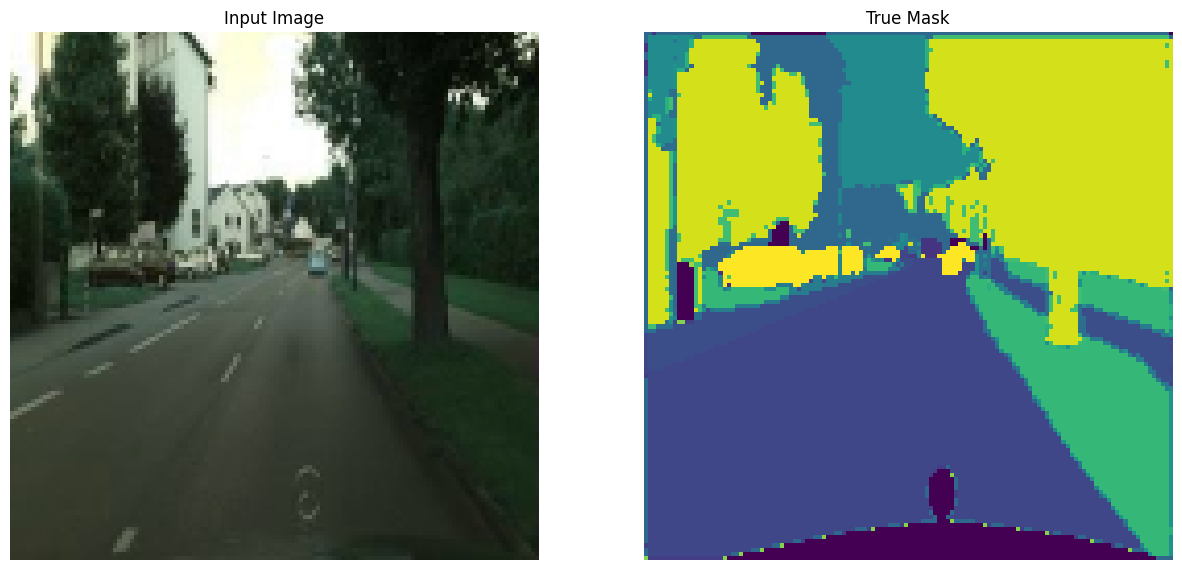

In [19]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [20]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [21]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [22]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x


In [23]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(n_classes, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model


In [24]:
unet_model = build_unet_model()

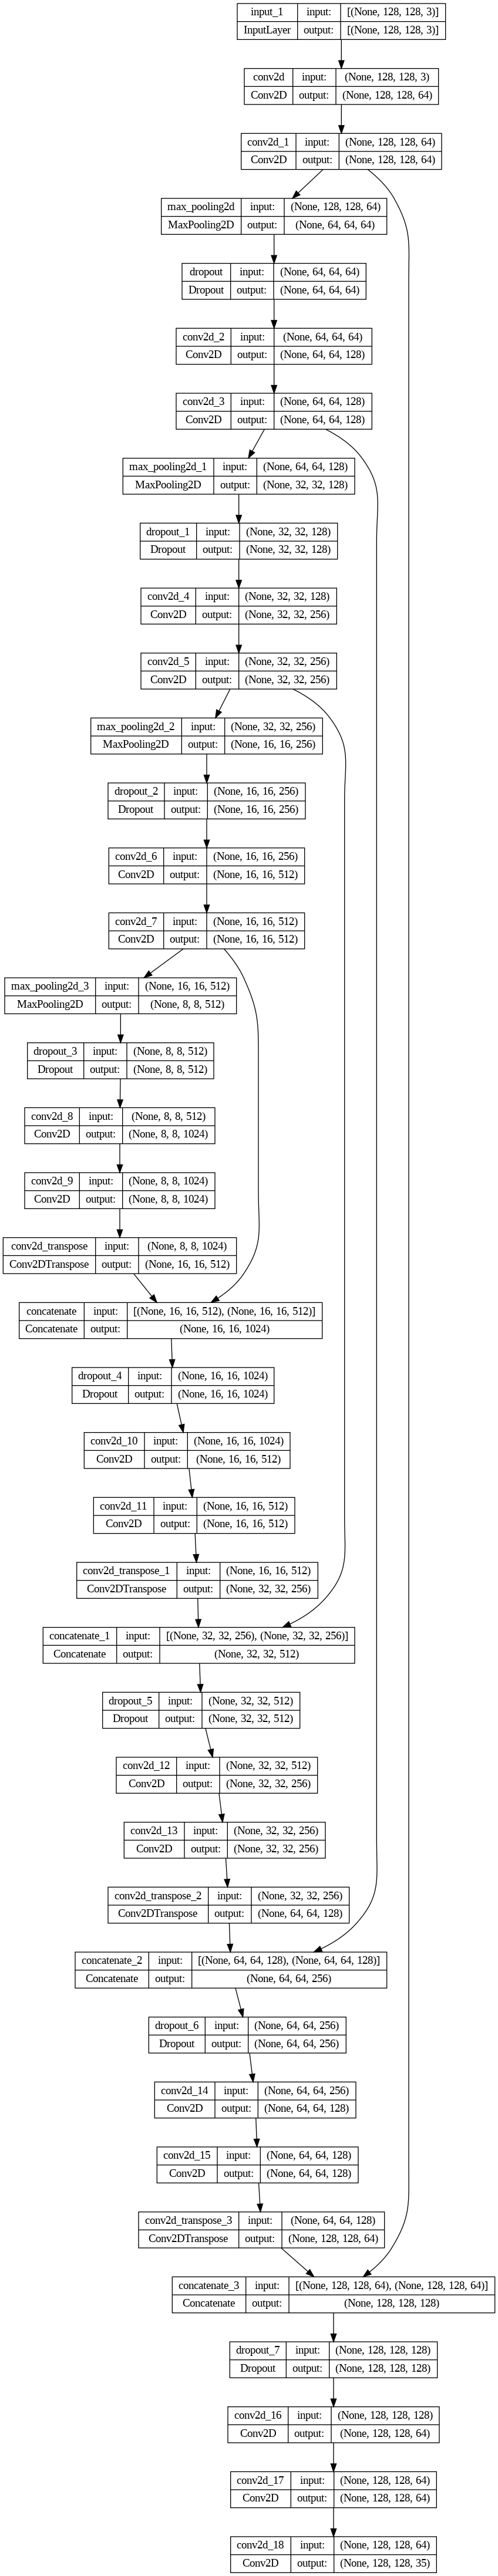

In [25]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [26]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [29]:
NUM_EPOCHS = 20
TRAIN_LENGTH = train_masks_enc.shape[0]
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = val_masks_enc.shape[0]
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches)

Epoch 1/20
46/46 [==============================] - 91s 1s/step - loss: 6.3584 - accuracy: 0.2983 - val_loss: 2.2070 - val_accuracy: 0.3876
Epoch 2/20
46/46 [==============================] - 60s 1s/step - loss: 2.1911 - accuracy: 0.4054 - val_loss: 2.0435 - val_accuracy: 0.4014
Epoch 3/20
46/46 [==============================] - 46s 1s/step - loss: 1.7362 - accuracy: 0.5239 - val_loss: 1.4445 - val_accuracy: 0.5822
Epoch 4/20
46/46 [==============================] - 46s 1s/step - loss: 1.3231 - accuracy: 0.6212 - val_loss: 1.2214 - val_accuracy: 0.6584
Epoch 5/20
46/46 [==============================] - 47s 1s/step - loss: 1.1661 - accuracy: 0.6680 - val_loss: 1.1513 - val_accuracy: 0.6764
Epoch 6/20
46/46 [==============================] - 47s 1s/step - loss: 1.0832 - accuracy: 0.6940 - val_loss: 1.1050 - val_accuracy: 0.6843
Epoch 7/20
46/46 [==============================] - 47s 1s/step - loss: 1.0171 - accuracy: 0.7142 - val_loss: 1.0461 - val_accuracy: 0.6964
Epoch 8/20
46/46 [==

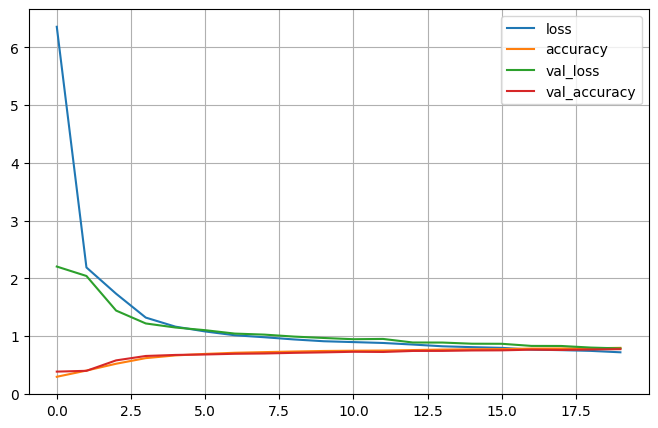

In [31]:
import pandas as pd
pd.DataFrame(model_history.history).plot(figsize = (8,5))
plt.grid(True)

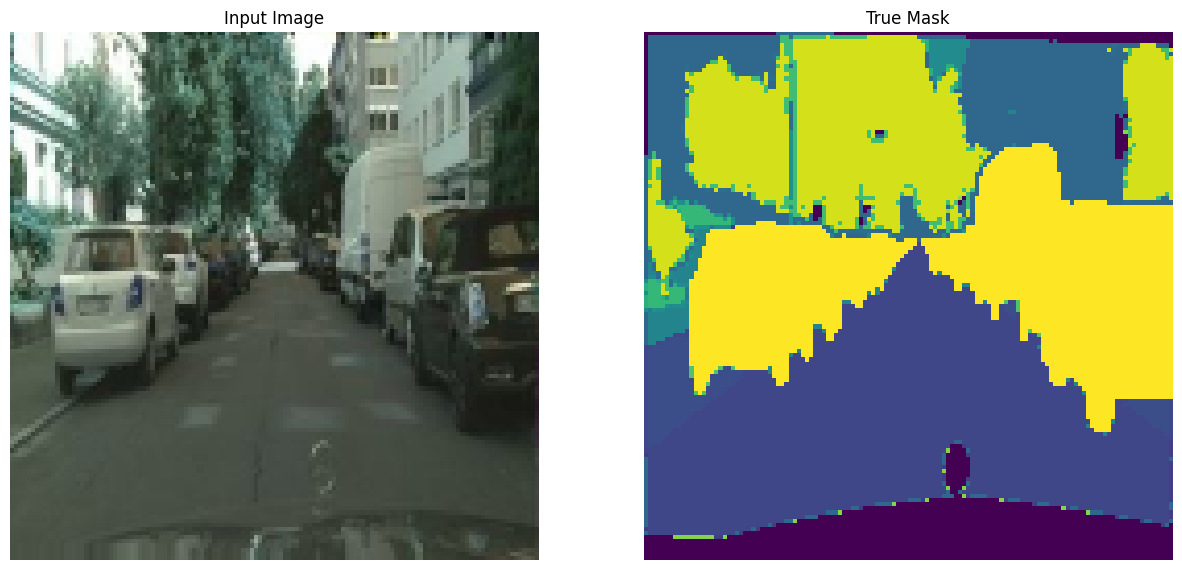

In [44]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

1/1 [==============================] - 0s 22ms/step


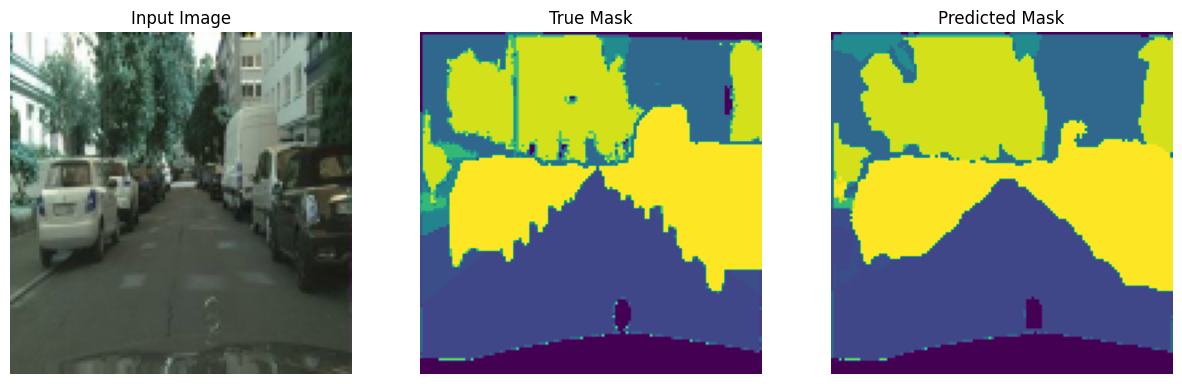

number of batches: 4


In [45]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]


display([sample_image, sample_mask, create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)